In [1]:
import pandas as pd            
import numpy as np             
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans, SpectralClustering
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from collections import Counter
%matplotlib inline

# Exercise 1

#### Read the data

In [2]:
# Read csv
original_data = pd.read_csv('CrowdstormingDataJuly1st.csv')
# Drop meaningless columns, we don't need the whole player name nor the birthday
original_data.drop(['player','birthday'], 1, inplace=True)
# Drop dyads where there are no photoID
original_data.dropna(axis=0, subset=['photoID'], inplace=True)
original_data.drop('photoID', 1, inplace=True)
# Drop dyads where there are no rating
original_data.dropna(axis=0, how='all', subset=['rater1', 'rater2'], inplace=True)
# Drop dyads where there is no position
original_data.dropna(axis=0, how='all', subset=['position'], inplace=True)

#### Drop the features we don't want

In [3]:
df = original_data.drop(['refNum', 'refCountry', 'Alpha_3', 'nIAT', 'nExp'], 1)

#### Weight the cards by IAT/Exp

IAT and Exp are linked to the referee and not directly to the player. The cards are what relates them. So let's try to weight the cards by IAT and Exp.

In [4]:
# IAT 
df['IATYellows'] = df['yellowCards']*df['meanIAT']+df['seIAT']
df['IATYellowReds'] = df['yellowReds']*df['meanIAT']+df['seIAT']
df['IATReds'] = df['redCards']*df['meanIAT']+df['seIAT']
# Exp
df['ExpYellows'] = df['yellowCards']*df['meanExp']+df['seExp']
df['ExpYellowReds'] = df['yellowReds']*df['meanExp']+df['seExp']
df['ExpReds'] = df['redCards']*df['meanExp']+df['seExp']

#### Aggregate some of the features

In [5]:
# Sum for aggregation
dfSumAgg = df[['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards',
                'IATYellows', 'IATYellowReds', 'IATReds', 'ExpYellows', 'ExpYellowReds', 'ExpReds']]
aggregatedWithSum = dfSumAgg.groupby('playerShort').sum()

# No sum for aggregation; also we don't take the IAT and Exp scores from the referees
identity = lambda x: x.iloc[0]
dfIdentityAgg = df[['playerShort', 'club', 'leagueCountry', 'height', 'weight', 'position', 
                     'rater1', 'rater2']]
aggregatedWithIdentity = dfIdentityAgg.groupby('playerShort').agg(identity)
dfd = pd.concat([aggregatedWithIdentity, aggregatedWithSum], axis=1)

#### Normalise/clean 

In [6]:
# victories, defeats, ties, goals, cards, etc -> 
#   for each player x: x._/x.games

colsToNorm = ['victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards',
             'IATYellows', 'IATYellowReds', 'IATReds', 'ExpYellows', 'ExpYellowReds', 'ExpReds']
ds = []
for c in colsToNorm:
    col = []
    for i in dfd.index:
        col.append(dfd[c].loc[i]/dfd['games'].loc[i])
    ds.append(pd.DataFrame(columns=[c], index=dfd.index, data=col))
    


dfd = pd.concat([pd.concat(ds,axis=1), dfd.drop(colsToNorm, axis=1)] ,axis=1)

In [7]:
# Deal with NaN in weight and height
# There are only few missing data so we can fill them with the mean of the column without
# inducing to much bias in the data

ws = dfd['weight']
meanW = ws.dropna().mean()
dfd['weight'].fillna(meanW, inplace=True)

hs = dfd['height']
meanH = hs.dropna().mean()
dfd['height'].fillna(meanH, inplace=True)

Since raters have a hard time to agree on a player skin color with the given scale, we decide to divide the observations in two sets:

In [75]:
meanColor = (dfd['rater1']+dfd['rater2'])/2
target = meanColor.apply(lambda x: 0 if x<0.5 else 1)

#### Encode the categorical features

In [24]:
le = preprocessing.LabelEncoder()
clubEncoded = pd.Series(index=data.index, data=le.fit_transform(data.club))
leagueCountreyEncoded = pd.Series(index=data.index, data=le.fit_transform(data.leagueCountry))
positionEncoded = pd.Series(index=data.index, data=le.fit_transform(data.position))

# Dataframe with categorical data encoded as ints
dataEncoded = pd.concat([clubEncoded, positionEncoded, leagueCountreyEncoded], axis=1)
dataEncoded.columns=['club', 'position', 'leagueCountry']

In [25]:
# One hot encoder
enc = preprocessing.OneHotEncoder()
enc.fit(dataEncoded)
oneHotEncodedData = enc.transform(dataEncoded).toarray()
#oneHotEncodedData.astype()
dfEncoded = pd.DataFrame(index=dataEncoded.index, data=oneHotEncodedData).astype(int)

In [26]:
# New data with categorical data encoded
dff = pd.concat([data.drop(['club','position','leagueCountry'], axis=1), dfEncoded], axis=1)

#### Start the machine larning part

In [27]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(dff, target, test_size=0.3, random_state=0)

In [59]:
# Classifier
# n_jobs=-1 sets it to the number of cores
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
print("Train accuracy: ", clf.score(X_train, y_train))
print("Test accuracy: ", clf.score(X_test, y_test))

Train accuracy:  0.979062811565
Test accuracy:  0.739534883721


Let's try to alter the parameters of the random forest to see how we can get overfitting. We see overfitting when the accuracy goes up on the training set and down on the test set. Let's first try with n_estimators, the number of trees in the forest.

In [29]:
train_accuracy = []
test_accuracy = []
estimator_range = range(1, 100)
for i in estimator_range:
    f = RandomForestClassifier(n_estimators=i)
    f.fit(X_train, y_train)
    train_accuracy.append(f.score(X_train, y_train))
    test_accuracy.append(f.score(X_test, y_test))

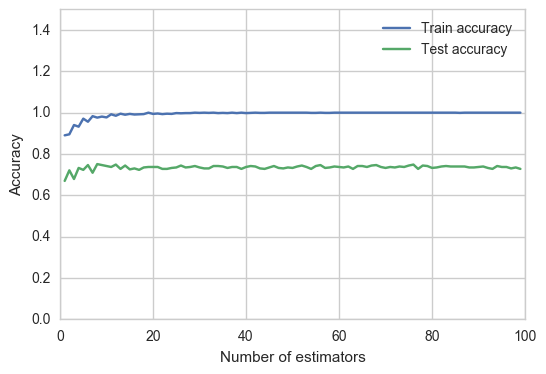

In [30]:
sns.set_style('whitegrid')
plt.plot(estimator_range, train_accuracy)
plt.plot(estimator_range, test_accuracy)
plt.legend(["Train accuracy", "Test accuracy"])
plt.ylim([0, 1.5])
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

All we can see there is that having too few estimators is bad. Let's try with bigger numbers

In [31]:
train_accuracy = []
test_accuracy = []
estimator_range = range(100, 1000, 50)
for i in estimator_range:
    f = RandomForestClassifier(n_estimators=i)
    f.fit(X_train, y_train)
    train_accuracy.append(f.score(X_train, y_train))
    test_accuracy.append(f.score(X_test, y_test))

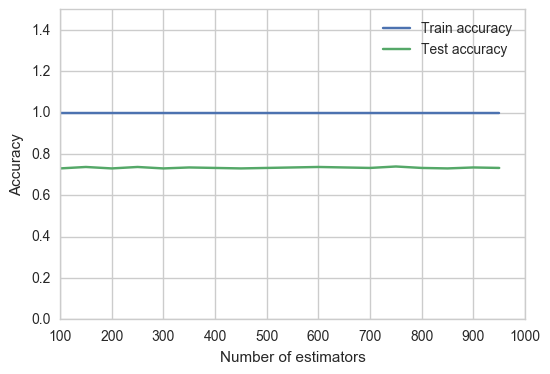

In [32]:
sns.set_style('whitegrid')
plt.plot(estimator_range, train_accuracy)
plt.plot(estimator_range, test_accuracy)
plt.legend(["Train accuracy", "Test accuracy"])
plt.ylim([0, 1.5])
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

Right. Doesn't look very concluding. Next, let's try with max_features, which is the number of features to consider when looking for the best split.

In [37]:
train_accuracy = []
test_accuracy = []
feature_range = range(1, X_train.columns.size)
for i in feature_range:
    f = RandomForestClassifier( max_features=i)
    f.fit(X_train, y_train)
    train_accuracy.append(f.score(X_train, y_train))
    test_accuracy.append(f.score(X_test, y_test))

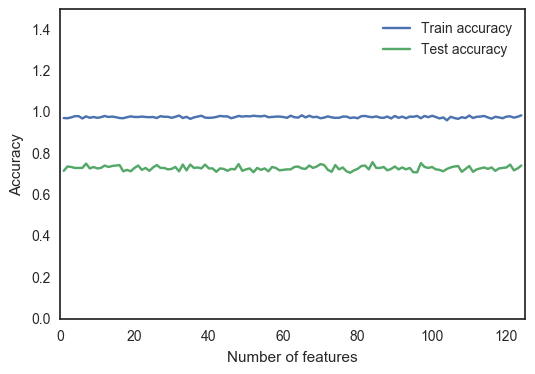

In [38]:
sns.set_style('white')
plt.plot(feature_range, train_accuracy)
plt.plot(feature_range, test_accuracy)
plt.legend(["Train accuracy", "Test accuracy"])
plt.xlim([0, 125])
plt.ylim([0, 1.5])
plt.xlabel("Number of features")
plt.ylabel("Accuracy")

Still nothing. Let's take a loot at the max depth of the trees through min_samples_split, _i.e._ the minimum number of samples required to split an internal node.

In [39]:
train_accuracy = []
test_accuracy = []
min_samples_split_range = range(2, 700, 5)
for i in min_samples_split_range:
    f = RandomForestClassifier(min_samples_split=i)
    f.fit(X_train, y_train)
    train_accuracy.append(f.score(X_train, y_train))
    test_accuracy.append(f.score(X_test, y_test))

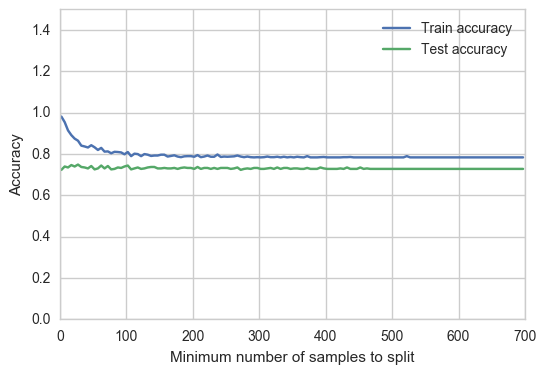

In [40]:
sns.set_style('whitegrid')
plt.plot(min_samples_split_range, train_accuracy)
plt.plot(min_samples_split_range, test_accuracy)
plt.legend(["Train accuracy", "Test accuracy"])
plt.xlim([0, 700])
plt.ylim([0, 1.5])
plt.xlabel("Minimum number of samples to split")
plt.ylabel("Accuracy")

We see that when the minimum number of samples to split is too small, the test accuracy decreases while the train accuracy increases. 

Now let's do cross validation:

In [70]:
clf = RandomForestClassifier(n_estimators=50, min_samples_split=400)
cross_val_score(clf, dff, target).mean()

0.76692357855945514

(array([ 1099.,   334.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

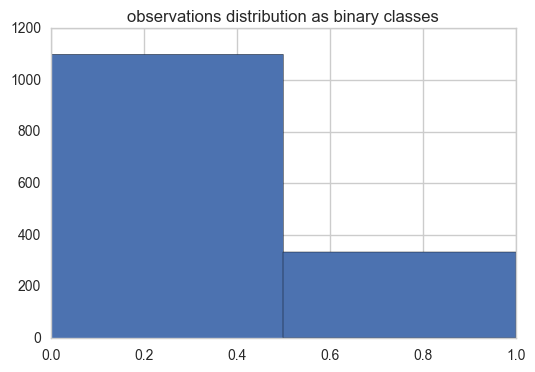

In [76]:
plt.title('observations distribution as binary classes')
plt.hist(target, bins=2)

We have seen that the distribution of the two classes are not the same. There is way more '0' class than the other this is why we have such accuracy, it is very likely that all samples are classed as 0. Let's inspect the confusion matrix below

We can see below in the confusion matrix, that all labels are predicted as '0' as expected

[[313   0]
 [117   0]]


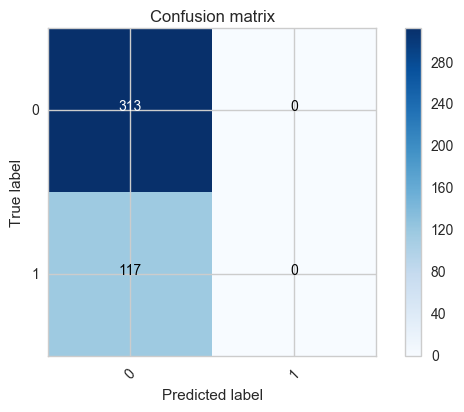

In [42]:
# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = RandomForestClassifier(n_estimators=50, min_samples_split=400)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
class_names =  np.array([0, 1]).astype('str')

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

#### Feature importance

(-1, 10)

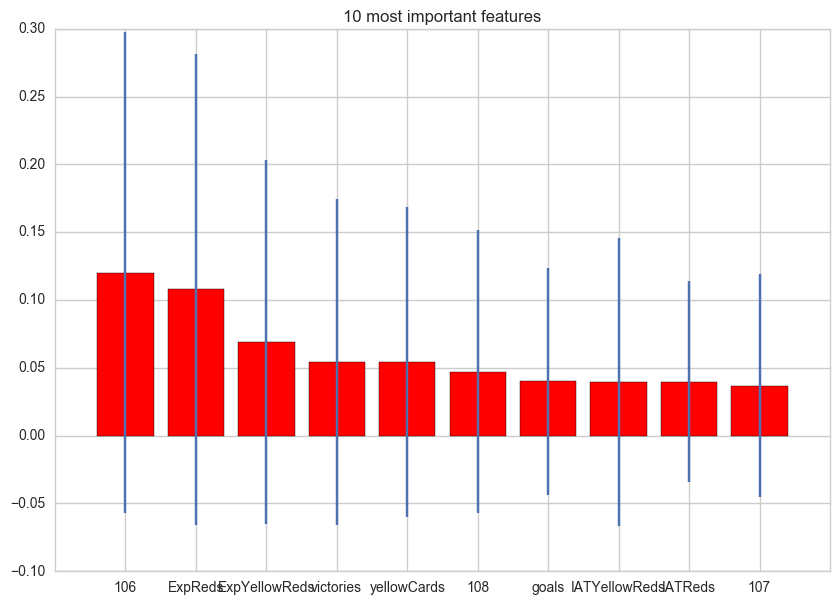

In [43]:
forest = clf
X = dff
y = target
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure(figsize=(10,7))
plt.title("10 most important features")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), X.columns[indices[0:10]])
plt.xlim([-1, 10])

We see that almost all the data linked to the cards are there, which seems reasonable. We also see the categorical features 105, 106, 107, and 108, which correspond respectively to the German, French, English and Spanish league. This makes sense; for examples South-American players have a stronger tendency to go in the Spanish League whereas Northern African players are often linked to France. Finally there is height, defeats, victories and games. Those four probably should not have such an impact. So let's try dropping all the features except the ones related to the cards as well as the leagues and positions.

In [77]:
dff2 = dff.drop(['victories', 'ties', 'defeats', 'goals', 'height', 'weight', 'games'], axis=1)
dff2.drop(list(range(0, 92)), axis = 1, inplace=True)

In [80]:
clf2 = RandomForestClassifier(n_estimators=50, min_samples_split=400)
cross_val_score(clf2, dff2, target).mean()

0.76692357855945514

Not much change. Let's take a look at the feature importance though.

(-1, 10)

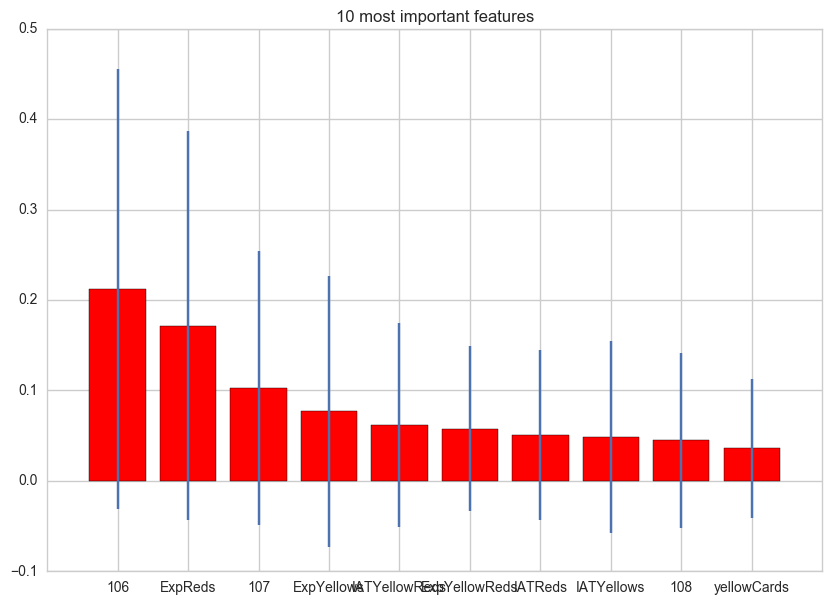

In [81]:
forest = clf2
X = dff2
y = target
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure(figsize=(10,7))
plt.title("10 most important features")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), X.columns[indices[0:10]])
plt.xlim([-1, 10])

We still get the leagues and the cards. However the prediction isn't really improved. Let's take a look at the distributions of the labels.

So our predictions, which are always in the 70% range, are similar to what we would get by always predicting 0. In other words, with the given data we can't predict the skin tone of a player. This seems pretty reasonable considering the data we have. The only really subjective data are the cards weighted by IAT/Exp. However we only have those values by country and not by referee. And since most of the referees come from the same countries, this is not very helpful.

Moreover since the distribution of the skin color is highly concentrated around 0. It is not hard to have a biased classifier on those labels. Looking at the confusion matrix above shows us that it is the case and that all predicted labels are 0

# Exercise 2

Here we compute the model, a mini batch kmeans, for possible combinations of features (and droping the worst feature at each new iteration)

We store the features used to calculate the silhouette score and the proportion elements per classe in the first cluster (since there are 2, only one is useful)

In [48]:
def name(x): 
    return dff2.columns[indices[x]]

In [49]:
# Take the 11th most important features according to ex1 (otherwise there are too many of them)
indicesToUse = indices[0:11]
# Init clustering model 
km = MiniBatchKMeans(n_clusters=2)
bestICSS = []
bestSS = []
proportions = []
y_train_floated = y_train.map(float)
lab, totals = zip(*sorted(Counter(y_train_floated).items()))
# Compute the model for possible combinations of features (and droping the worst feature at each new iteration)
for i in reversed(range(2,11)):
    print(i)
    c = itertools.combinations(indicesToUse, i)
    maxSS = -1
    acc = -1
    for ic in c:
        X_temp = X_train[dff2.columns[list(ic)]]
        km.fit(X_temp)
        labels = km.labels_
        ss = silhouette_score(X_temp, labels)
        
        if(ss > maxSS):
            maxSS = ss
            icBest = list(ic)
            clu1 = y_train[labels == 0]
            _, values = zip(*sorted(Counter(clu1).items()))
            values = [x/y for (x,y) in zip(values,totals)]


        
    bestICSS.append(icBest)
    bestSS.append(maxSS)
    proportions.append(values)

    ind = -1
    for x in indicesToUse:
        ind = ind + 1
        if x not in icBest:
            np.delete(indicesToUse, ind)
            break

print('DONE')

10
9
8
7
6
5
4
3
2
DONE


[94, 108, 92, 'ExpYellows', 99, 'ExpYellowReds', 98, 103, 106, 105]
[94, 108, 92, 'ExpYellows', 'ExpYellowReds', 101, 98, 106, 105]
[108, 'ExpYellows', 'ExpYellowReds', 101, 98, 103, 106, 105]
[108, 'ExpYellows', 'ExpYellowReds', 101, 98, 106, 105]
[108, 'ExpYellows', 'ExpYellowReds', 98, 103, 105]
[108, 'ExpYellows', 'ExpYellowReds', 101, 105]
[108, 'ExpYellows', 103, 105]
['ExpYellows', 103, 105]
[101, 105]


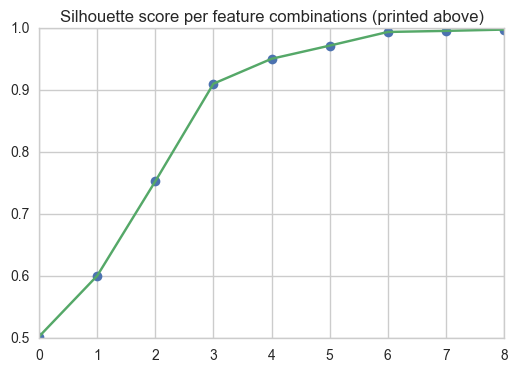

In [50]:
plt.plot(bestSS,'o', bestSS, '-')
plt.title('Silhouette score per feature combinations (printed above)')

combSS = [[name(x) for x in arr ] for arr in bestICSS]
_ =[print(x) for x in combSS]

Let us plot the proportional distribution of each class at each feature combination obtained above.
(For each class the distribution is the proportion of the class in the cluster)

Standard deviation 0.0727477398248


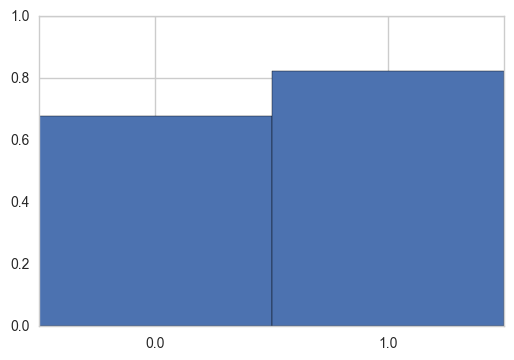

Standard deviation 0.0791940760545


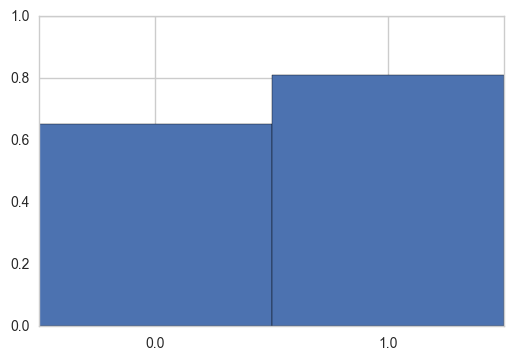

Standard deviation 0.0727477398248


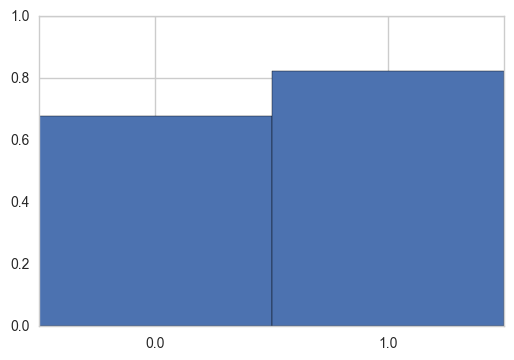

Standard deviation 0.0400206376567


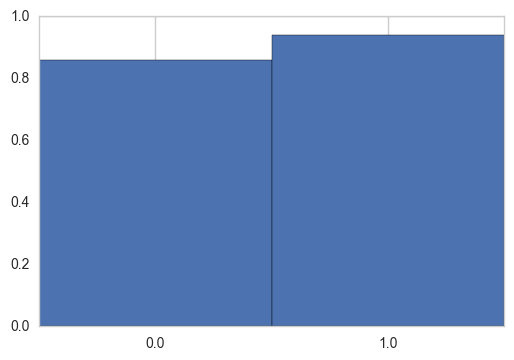

Standard deviation 0.0727477398248


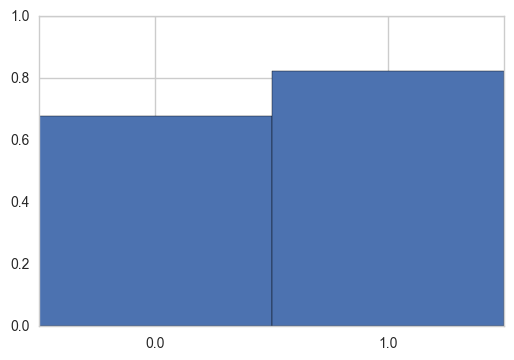

Standard deviation 0.0400206376567


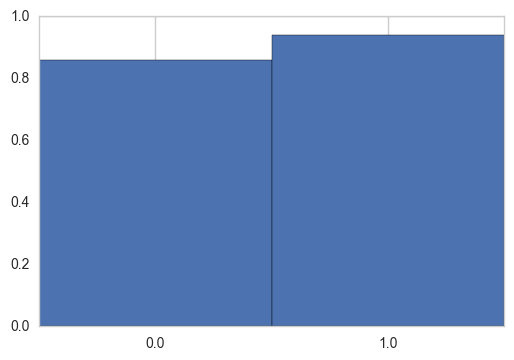

Standard deviation 0.0727477398248


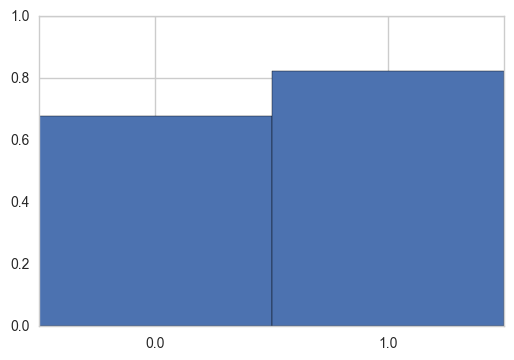

Standard deviation 0.0727477398248


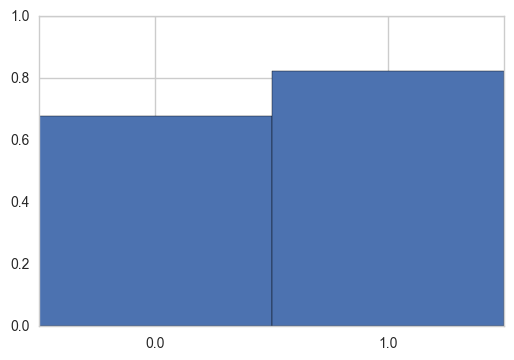

Standard deviation 0.0400206376567


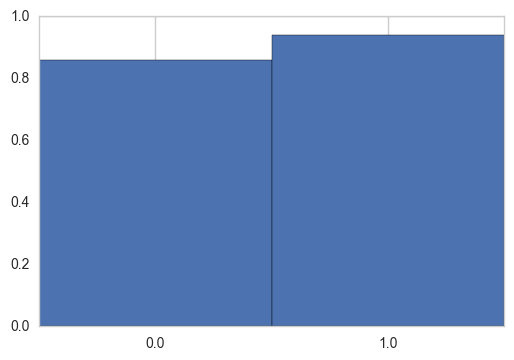

In [51]:
for vals in proportions:
        plt.figure()
        axes = plt.gca()
        axes.set_ylim([0.0,1.0])
        indexes = np.arange(len(lab))
        width = 1

        plt.bar(indexes, vals, width)
        plt.xticks(indexes + width * 0.5, lab)
        print('Standard deviation',np.array(vals).std())
        plt.show()

We can see that the less the features we have the higher the silhouette score is, this is the case because there are fewers parameters to satisfy in order to have isolated clusters.
We can also see that there are no cluster that discriminate on skin color when optimizing the silhouette score, at each step we can see the proportional distribution per class is pretty much the same (histograms above).

Let see if we have something different when trying to optimize the accuracy:


In [53]:
# Take the 11th most important features according to ex1 (otherwise there are too many of them)
indicesToUse = indices[0:11]
# Init clustering model 
km = MiniBatchKMeans(n_clusters=2)
bestICMet = []
bestMet = []
proportions = []
SS = []
y_train_floated = y_train.map(float)
lab, totals = zip(*sorted(Counter(y_train_floated).items()))
# Compute the model for possible combinations of features (and droping the worst feature at each new iteration)
for i in reversed(range(2,11)):
    print(i)
    c = itertools.combinations(indicesToUse, i)
    maxSS = -1
    maxMet = -1
    for ic in c:
        X_temp = X_train[dff2.columns[list(ic)]]
        km.fit(X_temp)
        clu1 = y_train[labels == 0]
        _, values = zip(*sorted(Counter(clu1).items()))
        values = [x/y for (x,y) in zip(values,totals)]
        met = abs(values[0] - (values[1]))
        if(met > maxMet):
            labels = km.labels_
            ss = silhouette_score(X_temp, labels)
            maxMet = met
            icBest = list(ic)
            
        
    bestICMet.append(icBest)
    bestMet.append(maxMet)
    proportions.append(values)
    SS.append(ss)
    
    ind = -1
    for x in indicesToUse:
        ind = ind + 1
        if x not in icBest:
            np.delete(indicesToUse, ind)
            break

print('DONE')

10
9
8
7
6
5
4
3
2
DONE


[92, 108, 100, 'IATYellows', 96, 'ExpYellows', 'IATReds', 103, 106, 'IATYellowReds']
[92, 108, 100, 'IATYellows', 'ExpYellows', 101, 'IATReds', 106, 'IATYellowReds']
[108, 'IATYellows', 'ExpYellows', 101, 'IATReds', 103, 106, 'IATYellowReds']
[108, 'IATYellows', 'ExpYellows', 101, 'IATReds', 106, 'IATYellowReds']
[108, 'IATYellows', 'ExpYellows', 'IATReds', 103, 'IATYellowReds']
[108, 'IATYellows', 'ExpYellows', 101, 'IATYellowReds']
[108, 'IATYellows', 103, 'IATYellowReds']
['IATYellows', 103, 'IATYellowReds']
[101, 'IATYellowReds']


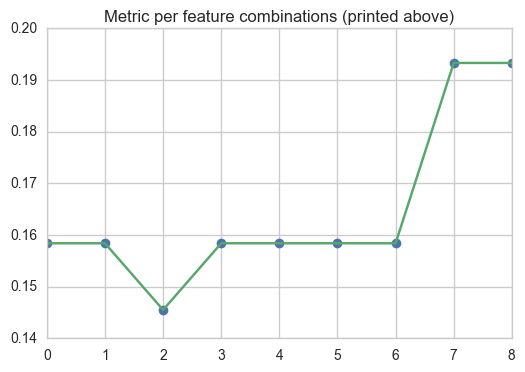

In [84]:
plt.plot(bestMet,'o', bestMet, '-')
plt.title('Metric per feature combinations (printed above)')

combSS = [[name(x) for x in arr ] for arr in bestICSS]
_ =[print(x) for x in combSS]

[94, 108, 92, 'ExpYellows', 99, 'ExpYellowReds', 101, 103, 106, 105]
[94, 108, 92, 'ExpYellows', 99, 'ExpYellowReds', 101, 98, 103]
[94, 108, 92, 'ExpYellows', 99, 'ExpYellowReds', 101, 98]
[94, 108, 92, 'ExpYellows', 99, 'ExpYellowReds', 98]
[94, 108, 92, 'ExpYellows', 99, 101]
[94, 108, 92, 'ExpYellows', 99]
[94, 108, 92, 99]
[94, 108, 99]
[94, 92]


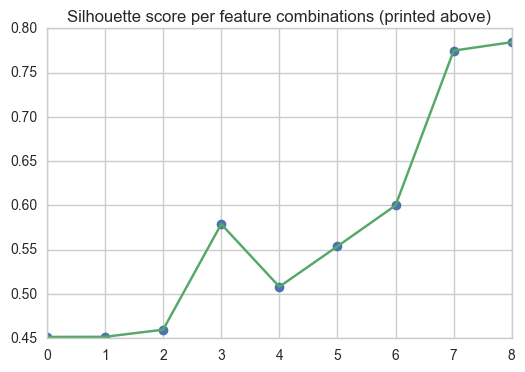

In [55]:
plt.plot(SS,'o', SS, '-')
plt.title('Silhouette score per feature combinations (printed above)')

combSS = [[name(x) for x in arr ] for arr in bestICMet]
_ =[print(x) for x in combSS]

Standard deviation 0.0791940760545


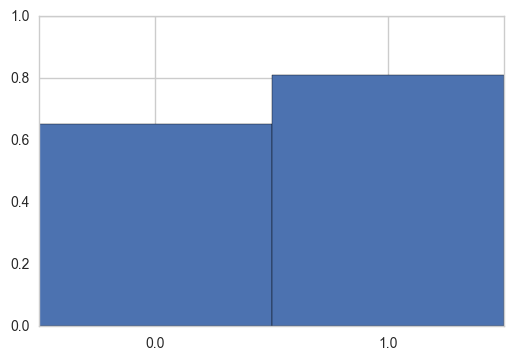

Standard deviation 0.0727477398248


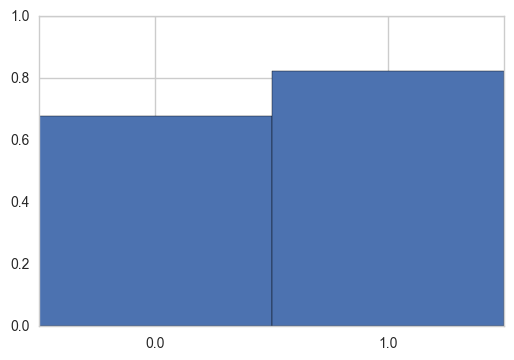

Standard deviation 0.0552966076852


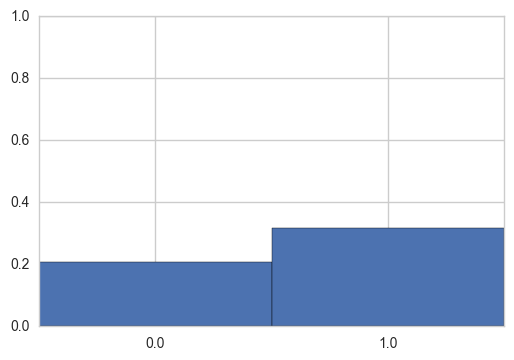

Standard deviation 0.0791940760545


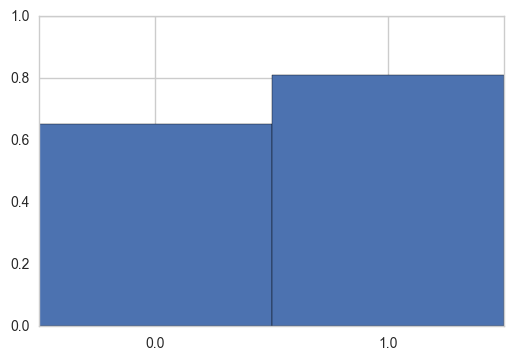

Standard deviation 0.0791940760545


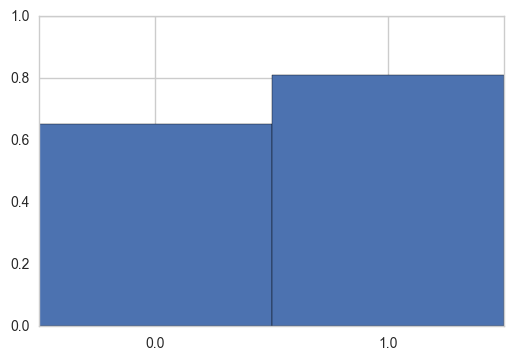

Standard deviation 0.0552966076852


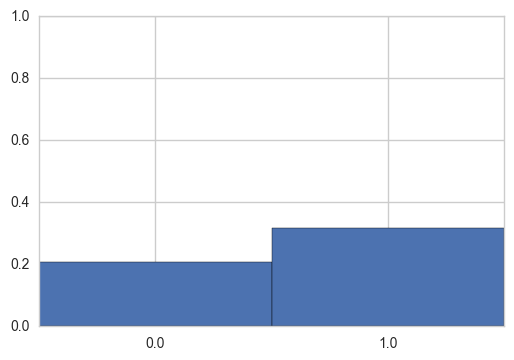

Standard deviation 0.0791940760545


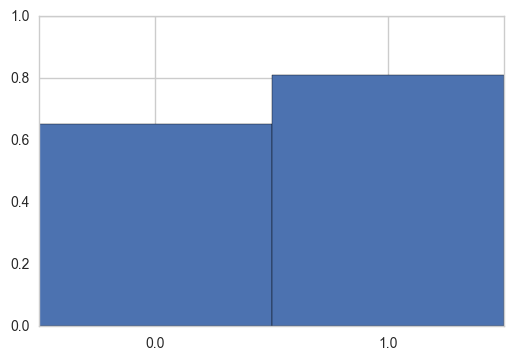

Standard deviation 0.0552966076852


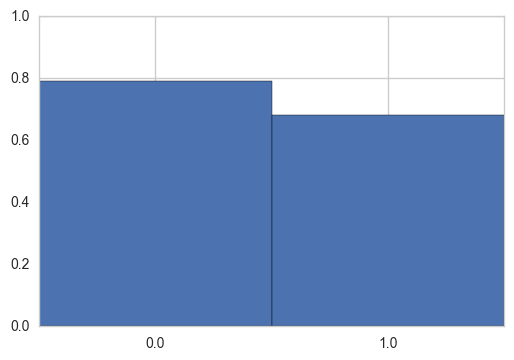

Standard deviation 0.0791940760545


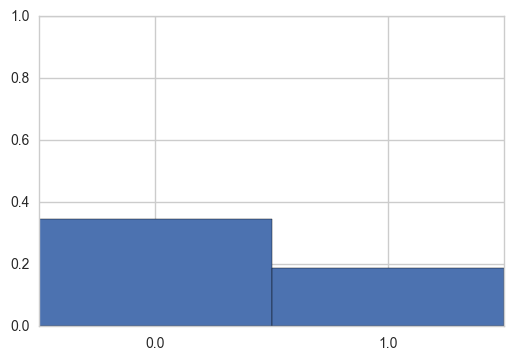

In [56]:
for vals in proportions:
        plt.figure()
        axes = plt.gca()
        axes.set_ylim([0.0,1.0])
        indexes = np.arange(len(lab))
        width = 1

        plt.bar(indexes, vals, width)
        plt.xticks(indexes + width * 0.5, lab)
        print('Standard deviation',np.array(vals).std())
        plt.show()

We can see that even when droping the features that maximise our metric:  
MAX(abs(#'0'/total('0') - #'1'/total('1')))

We still aren't able to discriminate per skin color with high silhouette score.
